# Propósito

Este notebook tem como objetivo realizar uma análise exploratória de algumas colunas de interesse das medições dos sensores de qualidade do ar.

O principal objetivo será preencher alguns valores nulos utilizando a função interpolate()

Mas para não enviesar muitos dados preencheremos apenas os valores em que a quantidade de valores nulas no dia semana menor que 7


# Importações

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
from scipy.stats import shapiro, anderson, boxcox, kstest, norm
from scipy.special import boxcox1p
from scipy import stats

# Consumindo bases

In [2]:
url_sensor = '/content/drive/MyDrive/TCC/sensores-2011-2021/medicao-sensores.csv'

df_sensor = pd.read_csv(url_sensor, sep=',')

url_estacoes = '/content/drive/MyDrive/TCC/sensores-2011-2021/estacoes.csv'

df_estacoes = pd.read_csv(url_estacoes, sep=',')

In [3]:
df_sensor.columns

Index(['objectid', 'data', 'codnum', 'estação', 'chuva', 'pres', 'rs', 'temp',
       'ur', 'dir_vento', 'vel_vento', 'so2', 'no2', 'hcnm', 'hct', 'ch4',
       'co', 'no', 'nox', 'o3', 'pm10', 'pm2_5', 'lat', 'lon',
       'x_utm_sirgas2000', 'y_utm_sirgas2000'],
      dtype='object')

# Pré-processamento

## Selecionando e criando colunas

In [4]:
#@title Criando coluna nome estacao com base na coluna codnum
df_sensor['nome_estacao'] = df_sensor['codnum'].map(df_estacoes.set_index('codnum')['nome'])

In [5]:
#@title Selecionando as colunas mais relevantes
interest_columns = ['nome_estacao', 'data', 'chuva', 'temp', 'ur', 'co', 'no', 'no2', 'nox', 'so2', 'o3', 'pm10', 'pm2_5']

df_sensor_interest = df_sensor[interest_columns]

In [6]:
#@title Criando colunas de ano e mês para facilitar a análise temporal
df_sensor_interest['data'] = pd.to_datetime(df_sensor_interest['data'], format='%Y/%m/%d %H:%M:%S+00')
df_sensor_interest['data_formatada'] = pd.to_datetime(df_sensor_interest['data']).dt.strftime('%Y-%m-%d')
df_sensor_interest['ano'] = df_sensor_interest['data'].dt.year
df_sensor_interest['mes'] = df_sensor_interest['data'].dt.month

<ipython-input-6-f9a423e0dd73>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_interest['data'] = pd.to_datetime(df_sensor_interest['data'], format='%Y/%m/%d %H:%M:%S+00')
<ipython-input-6-f9a423e0dd73>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_interest['data_formatada'] = pd.to_datetime(df_sensor_interest['data']).dt.strftime('%Y-%m-%d')
<ipython-input-6-f9a423e0dd73>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [7]:
#@title Removendo ano de 2011 (Pela falta de alguns poluente) e anos da pandemia
df_sensor_interest_filtered = df_sensor_interest[(df_sensor_interest['ano'] > 2011) & (df_sensor_interest['ano'] < 2020)]

In [8]:
#@title Filtrando por Tijuca
df_sensor_tijuca = df_sensor_interest_filtered[df_sensor_interest_filtered['nome_estacao'] == 'ESTAÇÃO TIJUCA']

# Tratando colunas de interesse por Estação de monitoriamento


## Estação Tijuca
Colunas normalizadas: Chuva, Temperatura, Umidade relativa, CO, NO, NO2, NOx, SO2, O3, PM10

### Chuva

In [9]:
df_sensor_tijuca['chuva'].describe()

,chuva
count,67848.000000
mean,0.091739
std,0.844936
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,48.400000


In [10]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_tijuca[df_sensor_tijuca['chuva'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 1026


In [11]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_tijuca['chuva_nulos_no_dia'] = (
    df_sensor_tijuca['chuva'].isnull()
    .groupby(df_sensor_tijuca['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-11-41133a260494>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_tijuca['chuva_nulos_no_dia'] = (


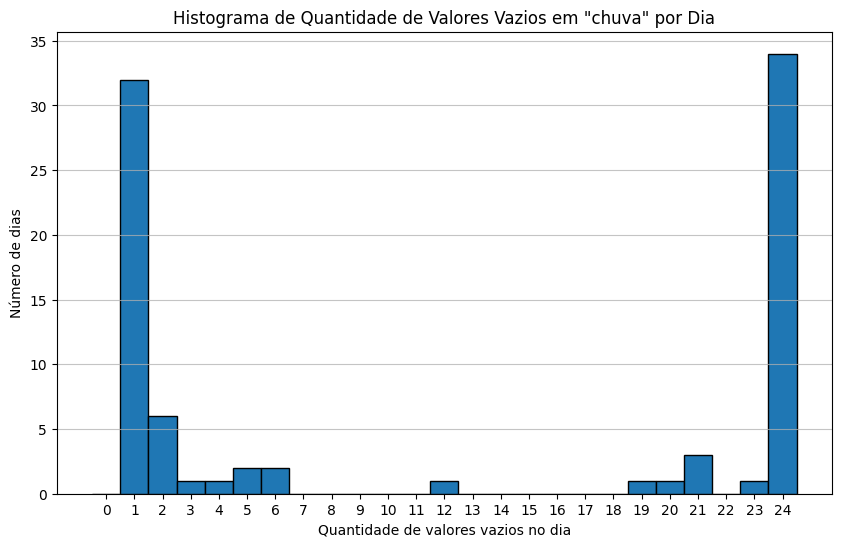

In [12]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_tijuca[df_sensor_tijuca['chuva_nulos_no_dia'] != 0].groupby('data_formatada')['chuva_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title('Histograma de Quantidade de Valores Vazios em "chuva" por Dia')
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [13]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias)

mask = (df_sensor_tijuca['chuva_nulos_no_dia'] <= 6)

num_nulls = df_sensor_tijuca[mask]['chuva'].isnull().sum()
df_sensor_tijuca.loc[mask, 'chuva'] = df_sensor_tijuca[mask]['chuva'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'chuva'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

73 linhas foram preenchidas com interpolate na coluna 'chuva'.
Foram preenchido 7% de dados


In [14]:
df_sensor_tijuca['chuva'].describe()

,chuva
count,67921.000000
mean,0.092049
std,0.846045
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,48.400000


### Temperatura

In [15]:
df_sensor_tijuca['temp'].describe()

,temp
count,67328.000000
mean,24.405158
std,5.646716
min,11.320000
25%,20.280000
50%,23.400000
75%,27.500000
max,46.170000


In [16]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_tijuca[df_sensor_tijuca['temp'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 1546


In [17]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_tijuca['temp_nulos_no_dia'] = (
    df_sensor_tijuca['temp'].isnull()
    .groupby(df_sensor_tijuca['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-17-54d899665637>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_tijuca['temp_nulos_no_dia'] = (


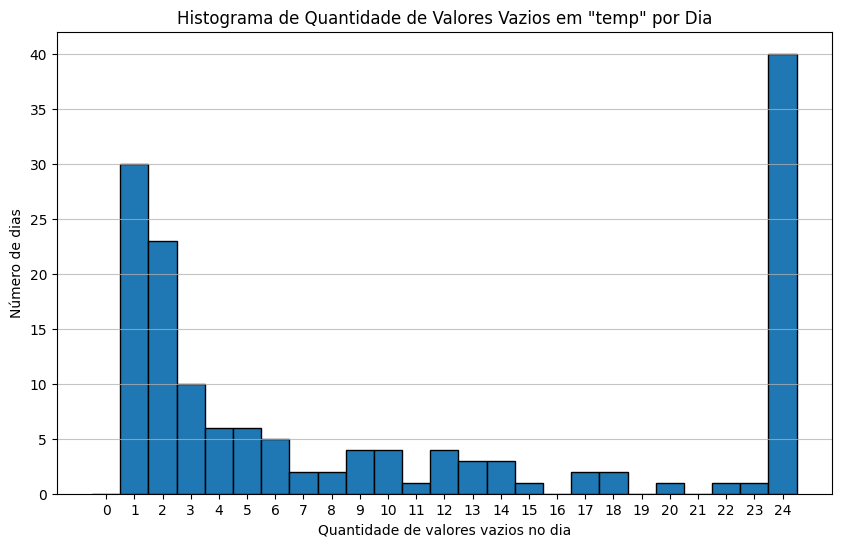

In [18]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_tijuca[df_sensor_tijuca['temp_nulos_no_dia'] != 0].groupby('data_formatada')['temp_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title('Histograma de Quantidade de Valores Vazios em "temp" por Dia')
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [19]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_tijuca['temp_nulos_no_dia'] <= 6)

num_nulls = df_sensor_tijuca[mask]['temp'].isnull().sum()
df_sensor_tijuca.loc[mask, 'temp'] = df_sensor_tijuca[mask]['temp'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'temp'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

190 linhas foram preenchidas com interpolate na coluna 'temp'.
Foram preenchido 12% de dados


In [20]:
df_sensor_tijuca['temp'].describe()

,temp
count,67518.000000
mean,24.407873
std,5.644357
min,11.320000
25%,20.282500
50%,23.400000
75%,27.500000
max,46.170000


### Umidade relativa

In [21]:
df_sensor_tijuca['ur'].describe()

,ur
count,68174.000000
mean,65.311974
std,19.436654
min,0.000000
25%,52.280000
50%,67.220000
75%,80.000000
max,98.980000


In [22]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_tijuca[df_sensor_tijuca['ur'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 700


In [23]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_tijuca['ur_nulos_no_dia'] = (
    df_sensor_tijuca['ur'].isnull()
    .groupby(df_sensor_tijuca['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-23-993d200eb480>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_tijuca['ur_nulos_no_dia'] = (


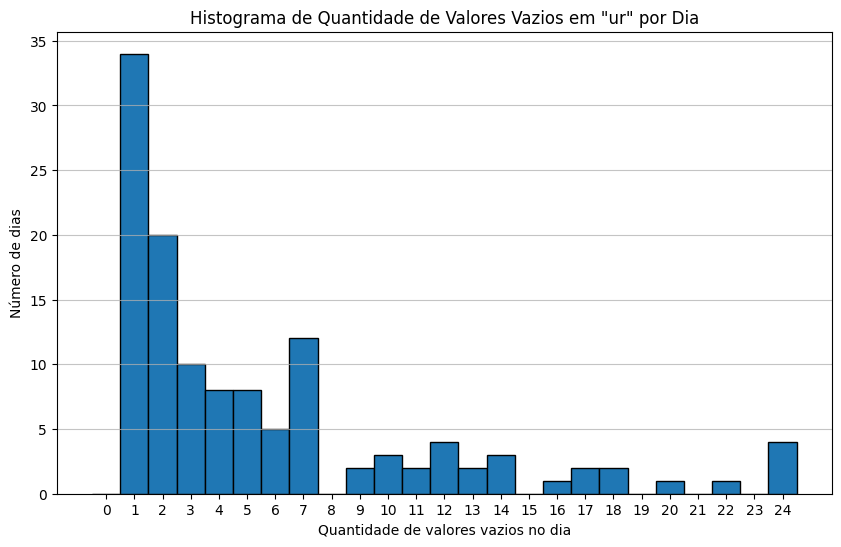

In [24]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_tijuca[df_sensor_tijuca['ur_nulos_no_dia'] != 0].groupby('data_formatada')['ur_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title('Histograma de Quantidade de Valores Vazios em "ur" por Dia')
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [25]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_tijuca['ur_nulos_no_dia'] <= 6)

num_nulls = df_sensor_tijuca[mask]['ur'].isnull().sum()
df_sensor_tijuca.loc[mask, 'ur'] = df_sensor_tijuca[mask]['ur'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'ur'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

206 linhas foram preenchidas com interpolate na coluna 'ur'.
Foram preenchido 29% de dados


In [26]:
df_sensor_tijuca['ur'].describe()

,ur
count,68380.000000
mean,65.312365
std,19.425162
min,0.000000
25%,52.300000
50%,67.200000
75%,79.980000
max,98.980000


### Monóxido de carbono

In [27]:
df_sensor_tijuca['co'].describe()

,co
count,66675.000000
mean,0.442921
std,0.251942
min,0.000000
25%,0.290000
50%,0.420000
75%,0.560000
max,12.080000


In [28]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_tijuca[df_sensor_tijuca['co'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 2199


In [29]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_tijuca['co_nulos_no_dia'] = (
    df_sensor_tijuca['co'].isnull()
    .groupby(df_sensor_tijuca['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-29-3fc7e038ecdb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_tijuca['co_nulos_no_dia'] = (


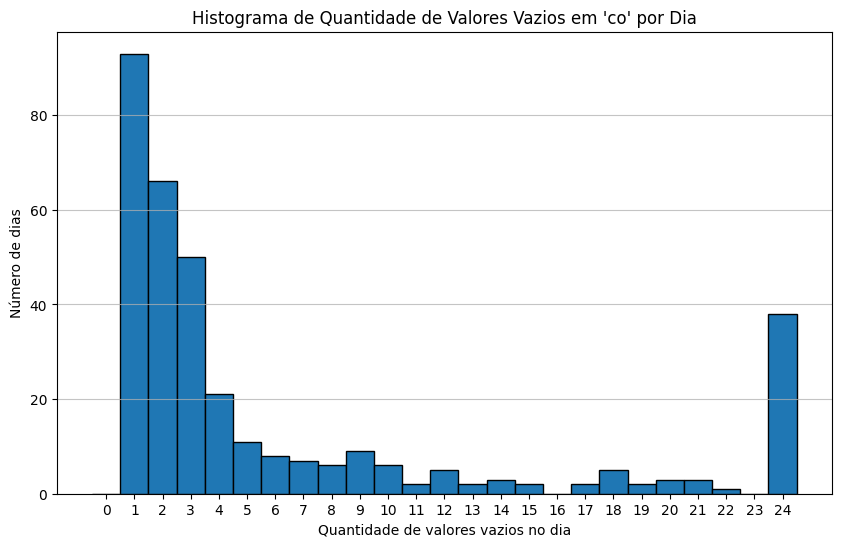

In [30]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_tijuca[df_sensor_tijuca['co_nulos_no_dia'] != 0].groupby('data_formatada')['co_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'co' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [31]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_tijuca['co_nulos_no_dia'] <= 6)

num_nulls = df_sensor_tijuca[mask]['co'].isnull().sum()
df_sensor_tijuca.loc[mask, 'co'] = df_sensor_tijuca[mask]['co'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'co'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

562 linhas foram preenchidas com interpolate na coluna 'co'.
Foram preenchido 26% de dados


In [32]:
df_sensor_tijuca['co'].describe()

,co
count,67237.000000
mean,0.443418
std,0.252225
min,0.000000
25%,0.290000
50%,0.420000
75%,0.560000
max,12.080000


### Monóxido de Nitrogênio

In [33]:
df_sensor_tijuca['no'].describe()

,no
count,48550.000000
mean,35.473496
std,26.562962
min,0.000000
25%,14.632500
50%,30.115000
75%,50.990000
max,241.840000


In [34]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_tijuca[df_sensor_tijuca['no'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 20324


In [35]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_tijuca['no_nulos_no_dia'] = (
    df_sensor_tijuca['no'].isnull()
    .groupby(df_sensor_tijuca['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-35-b0abafb7814e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_tijuca['no_nulos_no_dia'] = (


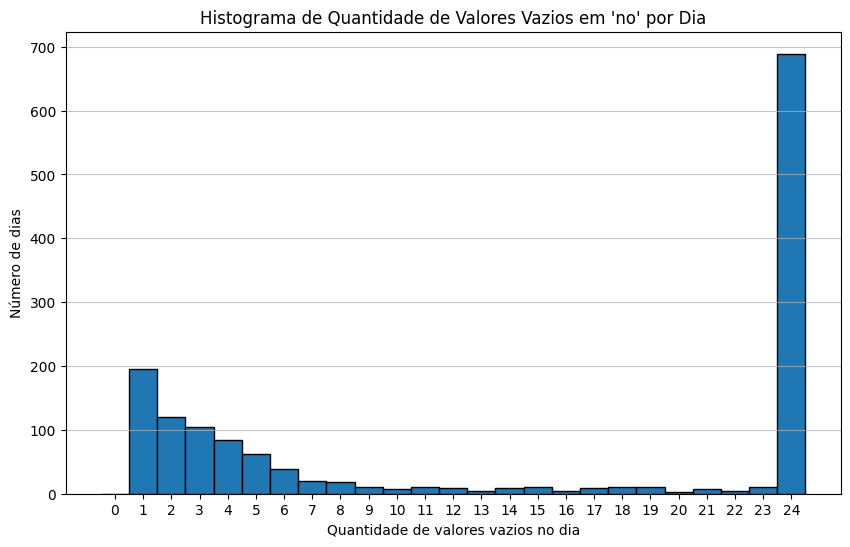

In [36]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_tijuca[df_sensor_tijuca['no_nulos_no_dia'] != 0].groupby('data_formatada')['no_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'no' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [37]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_tijuca['no_nulos_no_dia'] <= 6)

num_nulls = df_sensor_tijuca[mask]['no'].isnull().sum()
df_sensor_tijuca.loc[mask, 'no'] = df_sensor_tijuca[mask]['no'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'no'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

1627 linhas foram preenchidas com interpolate na coluna 'no'.
Foram preenchido 8% de dados


In [38]:
df_sensor_tijuca['no'].describe()

,no
count,50177.000000
mean,35.240638
std,26.411349
min,0.000000
25%,14.620000
50%,29.870000
75%,50.510000
max,241.840000


### Dióxido de Nitrogênio

In [39]:
df_sensor_tijuca['no2'].describe()

,no2
count,48550.000000
mean,42.255342
std,24.184659
min,0.000000
25%,24.230000
50%,38.730000
75%,55.420000
max,235.930000


In [40]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_tijuca[df_sensor_tijuca['no2'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 20324


In [41]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_tijuca['no2_nulos_no_dia'] = (
    df_sensor_tijuca['no2'].isnull()
    .groupby(df_sensor_tijuca['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-41-83bbbc5c7407>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_tijuca['no2_nulos_no_dia'] = (


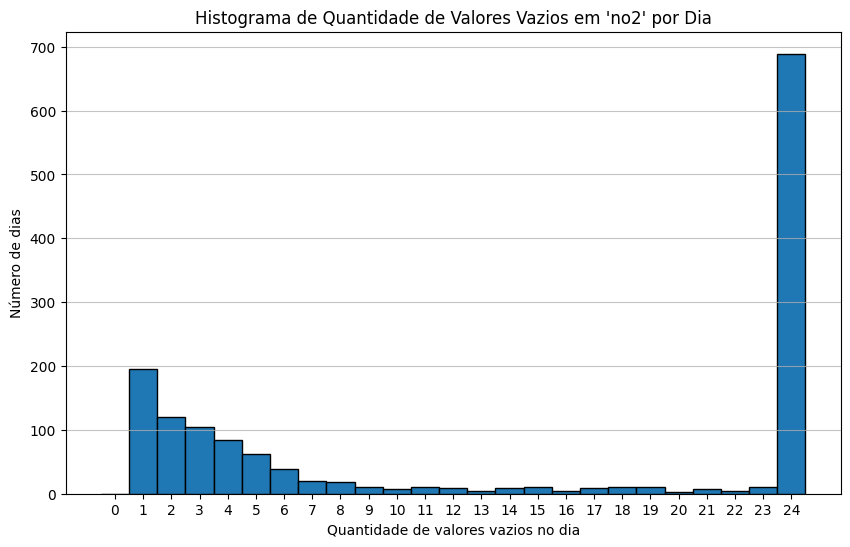

In [42]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_tijuca[df_sensor_tijuca['no2_nulos_no_dia'] != 0].groupby('data_formatada')['no2_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'no2' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [43]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_tijuca['no2_nulos_no_dia'] <= 6)

num_nulls = df_sensor_tijuca[mask]['no2'].isnull().sum()
df_sensor_tijuca.loc[mask, 'no2'] = df_sensor_tijuca[mask]['no2'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'no2'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

1627 linhas foram preenchidas com interpolate na coluna 'no2'.
Foram preenchido 8% de dados


In [44]:
df_sensor_tijuca['no2'].describe()

,no2
count,50177.000000
mean,41.912102
std,24.117962
min,0.000000
25%,23.960000
50%,38.280000
75%,55.000000
max,235.930000


### Óxido de Nitrogênio

In [45]:
df_sensor_tijuca['nox'].describe()

,nox
count,48553.000000
mean,57.685606
std,36.188502
min,0.000000
25%,32.110000
50%,51.150000
75%,74.850000
max,418.470000


In [46]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_tijuca[df_sensor_tijuca['nox'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 20321


In [47]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_tijuca['nox_nulos_no_dia'] = (
    df_sensor_tijuca['nox'].isnull()
    .groupby(df_sensor_tijuca['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-47-f4784ca56f30>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_tijuca['nox_nulos_no_dia'] = (


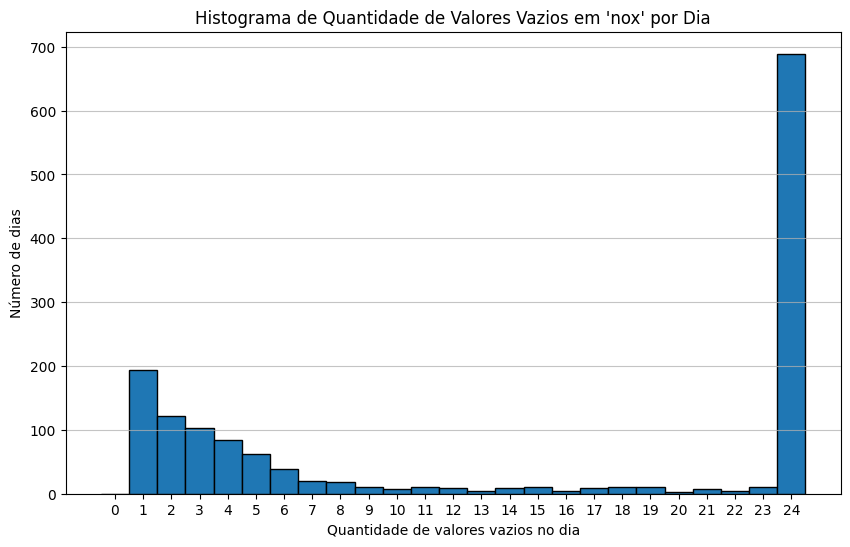

In [48]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_tijuca[df_sensor_tijuca['nox_nulos_no_dia'] != 0].groupby('data_formatada')['nox_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'nox' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [49]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_tijuca['nox_nulos_no_dia'] <= 6)

num_nulls = df_sensor_tijuca[mask]['nox'].isnull().sum()
df_sensor_tijuca.loc[mask, 'nox'] = df_sensor_tijuca[mask]['nox'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'nox'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

1624 linhas foram preenchidas com interpolate na coluna 'nox'.
Foram preenchido 8% de dados


In [50]:
df_sensor_tijuca['nox'].describe()

,nox
count,50177.000000
mean,57.108110
std,36.079029
min,0.000000
25%,31.570000
50%,50.420000
75%,74.180000
max,418.470000


### Dióxido de Enxofre Tijuca

In [51]:
df_sensor_tijuca['so2'].describe()

,so2
count,60951.000000
mean,3.800555
std,6.004629
min,0.000000
25%,0.710000
50%,1.870000
75%,4.300000
max,159.820000


In [52]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_tijuca[df_sensor_tijuca['so2'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 7923


In [53]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_tijuca['so2_nulos_no_dia'] = (
    df_sensor_tijuca['so2'].isnull()
    .groupby(df_sensor_tijuca['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-53-1ed7caa1631b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_tijuca['so2_nulos_no_dia'] = (


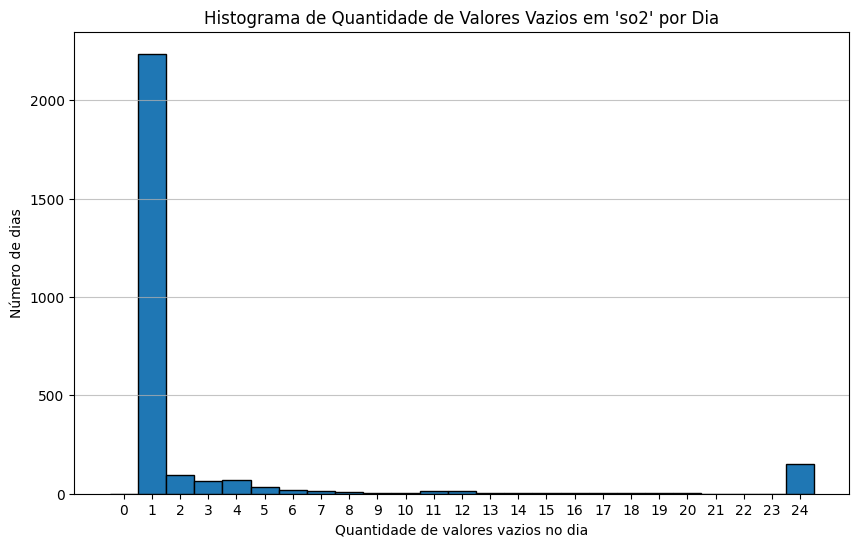

In [54]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_tijuca[df_sensor_tijuca['so2_nulos_no_dia'] != 0].groupby('data_formatada')['so2_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'so2' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [55]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_tijuca['so2_nulos_no_dia'] <= 6)

num_nulls = df_sensor_tijuca[mask]['so2'].isnull().sum()
df_sensor_tijuca.loc[mask, 'so2'] = df_sensor_tijuca[mask]['so2'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'so2'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

3188 linhas foram preenchidas com interpolate na coluna 'so2'.
Foram preenchido 40% de dados


In [56]:
df_sensor_tijuca['so2'].describe()

,so2
count,64139.000000
mean,3.747956
std,5.934281
min,0.000000
25%,0.700000
50%,1.840000
75%,4.250000
max,159.820000


### Ozônio Tijuca

In [57]:
df_sensor_tijuca['o3'].describe()

,o3
count,64726.000000
mean,28.630406
std,25.109902
min,0.000000
25%,10.140000
50%,22.930000
75%,39.497500
max,295.490000


In [58]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_tijuca[df_sensor_tijuca['o3'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 4148


In [59]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_tijuca['o3_nulos_no_dia'] = (
    df_sensor_tijuca['o3'].isnull()
    .groupby(df_sensor_tijuca['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-59-ba670d760c2d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_tijuca['o3_nulos_no_dia'] = (


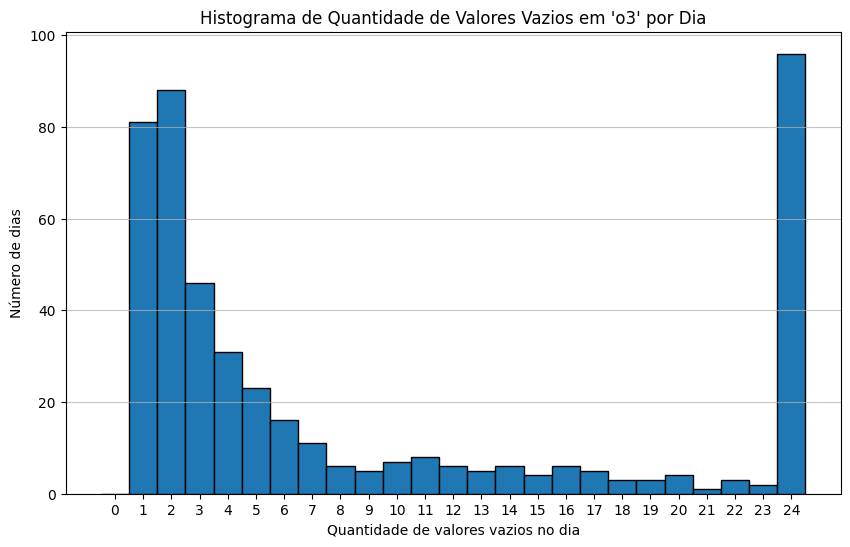

In [60]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_tijuca[df_sensor_tijuca['o3_nulos_no_dia'] != 0].groupby('data_formatada')['o3_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'o3' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [61]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_tijuca['o3_nulos_no_dia'] <= 6)

num_nulls = df_sensor_tijuca[mask]['o3'].isnull().sum()
df_sensor_tijuca.loc[mask, 'o3'] = df_sensor_tijuca[mask]['o3'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'o3'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

730 linhas foram preenchidas com interpolate na coluna 'o3'.
Foram preenchido 18% de dados


In [62]:
df_sensor_tijuca['o3'].describe()

,o3
count,65456.000000
mean,28.655693
std,25.057591
min,0.000000
25%,10.230000
50%,22.990000
75%,39.500000
max,295.490000


### PM10 Tijuca

In [63]:
df_sensor_tijuca['pm10'].describe()

,pm10
count,66815.000000
mean,32.800977
std,18.754760
min,0.000000
25%,20.530000
50%,29.100000
75%,40.490000
max,310.310000


In [64]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_tijuca[df_sensor_tijuca['pm10'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 2059


In [65]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_tijuca['pm10_nulos_no_dia'] = (
    df_sensor_tijuca['pm10'].isnull()
    .groupby(df_sensor_tijuca['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-65-2bd8e50c63a9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_tijuca['pm10_nulos_no_dia'] = (


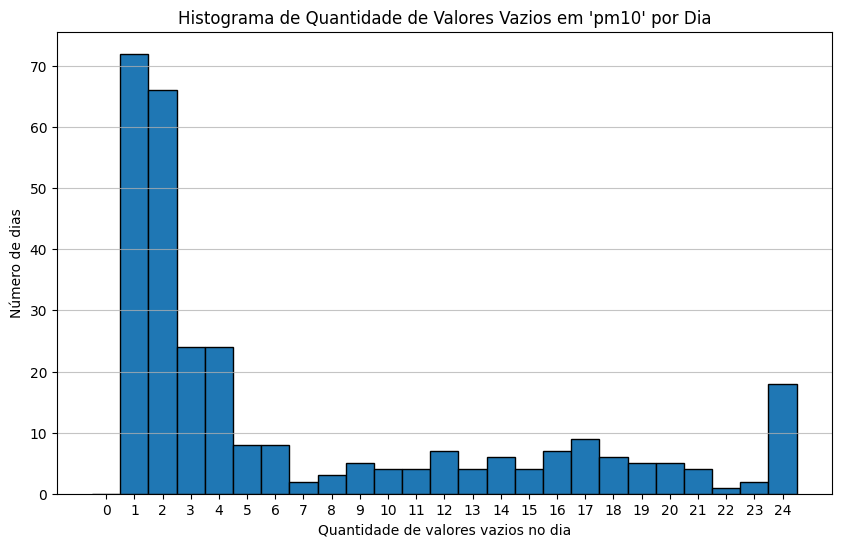

In [66]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_tijuca[df_sensor_tijuca['pm10_nulos_no_dia'] != 0].groupby('data_formatada')['pm10_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'pm10' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [67]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_tijuca['pm10_nulos_no_dia'] <= 6)

num_nulls = df_sensor_tijuca[mask]['pm10'].isnull().sum()
df_sensor_tijuca.loc[mask, 'pm10'] = df_sensor_tijuca[mask]['pm10'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'pm10'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

460 linhas foram preenchidas com interpolate na coluna 'pm10'.
Foram preenchido 22% de dados


In [68]:
df_sensor_tijuca['pm10'].describe()

,pm10
count,67275.000000
mean,32.807955
std,18.788525
min,0.000000
25%,20.520000
50%,29.110000
75%,40.510000
max,310.310000


# Gerando CSV de saída com a estação de Tijuca preenchida


In [69]:
droping_columns = ['chuva_nulos_no_dia', 'temp_nulos_no_dia', 'ur_nulos_no_dia', 'co_nulos_no_dia', 'no_nulos_no_dia', 'no2_nulos_no_dia', 'nox_nulos_no_dia', 'so2_nulos_no_dia', 'o3_nulos_no_dia', 'pm10_nulos_no_dia']

df_sensor_tijuca.drop(columns=droping_columns, inplace=True)

<ipython-input-69-0661f69e08f5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_tijuca.drop(columns=droping_columns, inplace=True)


In [70]:
df_sensor_tijuca.to_csv('df_sensor_tijuca_preenchido.csv', index=False)